In [1]:
### Package Imports ###
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, root_mean_squared_error
import xgboost as xgb
import shap 
from imblearn.under_sampling import RandomUnderSampler

In [2]:
### Data Import ###
data = pd.read_csv('./data/telco/Telco-Customer-Churn.csv', na_values=[' '])

### Pre-Processing ###
# Drop NaN rows
data = data.dropna(axis=0)

# Map gender column to binary values
gender_mapping = {'Male': 1, 'Female': 0}
data['gender'] = data['gender'].map(lambda x: 1 if x == 'Male' else 0)

# Map "No phone service" to "No"
data['MultipleLines'] = data['MultipleLines'].map(lambda x: 'No' if x == 'No phone service' else x)

# Map "No internet service" to "No"
internet_services_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data[internet_services_columns] = data[internet_services_columns].map(lambda x: "No" if x == "No internet service" else x)

# Map No to 0 and Yes to 1
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] + internet_services_columns
data[yes_no_columns] = data[yes_no_columns].map(lambda x: 0 if x == "No" else 1)

# Change TotalCharges dtype
data['TotalCharges'] = data['TotalCharges'].astype(float)

# Reformat PaymentMethod column
payment_method_mapping = {'Bank transfer (automatic)': 'BankTransfer', 'Credit card (automatic)': 'CreditCard', 'Electronic check': 'ElectronicCheck', 'Mailed check': 'MailedCheck'}
data['PaymentMethod'] = data['PaymentMethod'].replace(payment_method_mapping)

# Reformat Contract column
contract_mapping = {'Month-to-month': 'MonthToMonth', 'One year': 'OneYear', 'Two year': 'TwoYear'}
data['Contract'] = data['Contract'].map(contract_mapping)

# Reformat InternetService column
internet_service_mapping = {'Fiber optic': 'FiberOptic', 'DSL': 'DSL'}
data['InternetService'] = data['InternetService'].map(internet_service_mapping)

In [3]:
# Test: Remove most important feature to determine over-fitting to feature
#data = data[data['Contract'] != 'MonthToMonth']

In [4]:
### XGBoost Algorithm ### 
# Splitting the data into train and test sets
X = data.drop(['customerID','Churn'], axis=1)  # Features
y = data['Churn']  # Target variable

# Random under sampling (the training set) to balance the dataset
rus = RandomUnderSampler(random_state=42, replacement=False)
X, y = rus.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# # Random under sampling (the training set) to balance the dataset
# rus = RandomUnderSampler(random_state=42, replacement=False)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# # Calculate weights for reweighing
# class_counts = y_train.value_counts()
# total_count = len(y_train)
# class_weights = {cls: total_count / (2*count) for cls, count in class_counts.items()}

# Perform one-hot encoding for categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 5],
    'learning_rate': [ 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_encoded, y_train) #, sample_weight=y_train.map(class_weights))

#print(grid_search.cv_results_)
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
print(f"Confusion matrix: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp} \n", conf_mat)
print(f'AUC score: {round(roc_auc_score(y_test, y_pred),2)}')

Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.72      0.78       200
           1       0.73      0.84      0.78       174

    accuracy                           0.78       374
   macro avg       0.78      0.78      0.78       374
weighted avg       0.79      0.78      0.78       374

Confusion matrix: TN: 145, FP: 55, FN: 28, TP: 146 
 [[145  55]
 [ 28 146]]
AUC score: 0.78


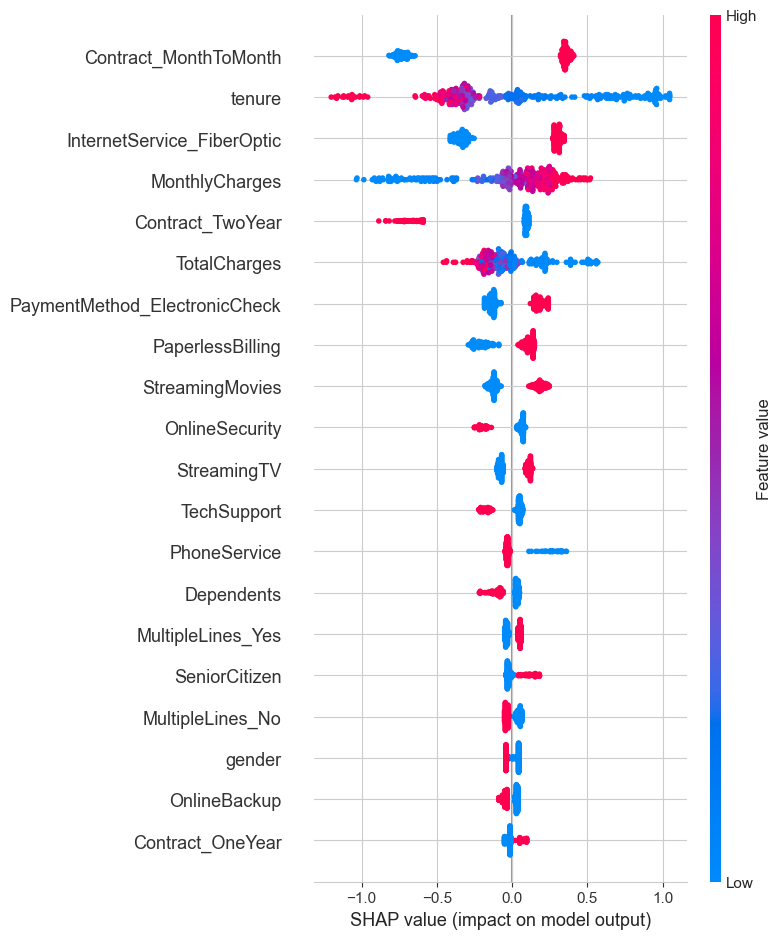

In [5]:
### Model Explanation using Shapley Values ###
# Initialize an explainer with the best model's predict method
explainer = shap.Explainer(best_model)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_encoded)

In [6]:
def shapley_feature_ranking(shap_values, X):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {
            "features": [X.columns[i] for i in feature_order][::-1],
            "importance": [
                np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )

In [7]:
feature_ranking = shapley_feature_ranking(shap_values, X_test_encoded)
feature_ranking['normalized_importance'] = feature_ranking['importance'] / sum(feature_ranking['importance'])
feature_ranking

,features,importance,normalized_importance
0,Contract_MonthToMonth,0.501670,0.164664
1,tenure,0.456771,0.149927
2,InternetService_FiberOptic,0.322251,0.105773
3,MonthlyCharges,0.264469,0.086807
4,Contract_TwoYear,0.208326,0.068379
5,TotalCharges,0.156606,0.051403
6,PaymentMethod_ElectronicCheck,0.156198,0.051269
7,PaperlessBilling,0.150282,0.049327
8,StreamingMovies,0.148871,0.048864
9,OnlineSecurity,0.100912,0.033122


In [8]:
columns_to_drop = feature_ranking[feature_ranking["normalized_importance"] < 0.1]['features'].tolist()
print(columns_to_drop)

['MonthlyCharges', 'Contract_TwoYear', 'TotalCharges', 'PaymentMethod_ElectronicCheck', 'PaperlessBilling', 'StreamingMovies', 'OnlineSecurity', 'StreamingTV', 'TechSupport', 'PhoneService', 'Dependents', 'MultipleLines_Yes', 'SeniorCitizen', 'MultipleLines_No', 'gender', 'OnlineBackup', 'Contract_OneYear', 'PaymentMethod_CreditCard', 'DeviceProtection', 'PaymentMethod_BankTransfer', 'InternetService_DSL', 'Partner', 'PaymentMethod_MailedCheck']


In [9]:
# Drop non-important features from X_train and X_test
X_train_encoded = X_train_encoded.drop(columns=columns_to_drop)
X_test_encoded = X_test_encoded.drop(columns=columns_to_drop)

In [10]:
### XGBoost Algorithm with Important Features Only ### 
# Define XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 5],
    'learning_rate': [ 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_encoded, y_train) #, sample_weight=y_train.map(class_weights))

#print(grid_search.cv_results_)
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

# Evaluate the model
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(classification_report(y_test, y_pred))
print("Confusion matrix: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp} \n", conf_mat)
print(f'AUC score: {round(roc_auc_score(y_test, y_pred),2)}')
print(f'RMSE: {round(root_mean_squared_error(y_test, y_pred),2)}')

Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       200
           1       0.71      0.75      0.73       174

    accuracy                           0.74       374
   macro avg       0.74      0.74      0.74       374
weighted avg       0.74      0.74      0.74       374

Confusion matrix: TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp} 
 [[146  54]
 [ 44 130]]
AUC score: 0.74
RMSE: 0.51


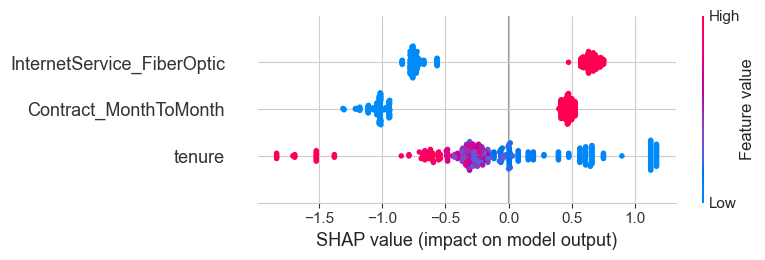

In [11]:
### Model Explanation using Shapley Values ###
# Initialize an explainer with the best model's predict method
explainer = shap.Explainer(best_model)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_encoded)

In [12]:
feature_ranking = shapley_feature_ranking(shap_values, X_test_encoded)
feature_ranking

,features,importance
0,InternetService_FiberOptic,0.694601
1,Contract_MonthToMonth,0.679872
2,tenure,0.510809


In [13]:
## Create train and test csvs for EDHiE
EDHiE_train = pd.concat([X_train_encoded, y_train], axis=1)
EDHiE_test = pd.concat([X_test_encoded, y_test], axis=1)

# Turn boolean columns into int columns
boolean_cols = EDHiE_train.select_dtypes(include=['bool']).columns
EDHiE_train[boolean_cols] = EDHiE_train[boolean_cols].astype(int)
EDHiE_test[boolean_cols] = EDHiE_test[boolean_cols].astype(int)

# Save to csv in correct format (no index or header)
path = "../HVAE-master/data/telco/"
EDHiE_train.to_csv(path_or_buf=path+'telco3var_train.csv', header=False, index=False)
EDHiE_test.to_csv(path_or_buf=path+'telco3var_test.csv', header=False, index=False)

In [14]:
# print out variable names for EDHiE
print(f'Variable A will represent {EDHiE_train.columns[0]} ({X_train_encoded[EDHiE_train.columns[0]].dtype})')
print(f'Variable B will represent {EDHiE_train.columns[1]} ({X_train_encoded[EDHiE_train.columns[1]].dtype})')
print(f'Variable C will represent {EDHiE_train.columns[2]} ({X_train_encoded[EDHiE_train.columns[2]].dtype})')

print(f'The target column is {EDHiE_train.columns[-1]} ({y_train.dtype})')

Variable A will represent tenure (int64)
Variable B will represent InternetService_FiberOptic (bool)
Variable C will represent Contract_MonthToMonth (bool)
The target column is Churn (int64)
